In [1]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input, ReLU, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# 모델 정의
def build_advanced_srcnn():
    inputs = Input(shape=(FIXED_SIZE[0], FIXED_SIZE[1], 3))
    x = Conv2D(128, (9, 9), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(64, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(64, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, (3, 3), padding='same')(x)
    outputs = Add()([inputs, x])  # Residual 연결
    
    return Model(inputs, outputs)

In [ ]:
# 이미지 전처리 함수
def preprocess_pair_fixed(image_path, upscale_factor=2):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"이미지를 불러올 수 없습니다: {image_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, FIXED_SIZE)

    lr = cv2.resize(img, (FIXED_SIZE[0] // upscale_factor, FIXED_SIZE[1] // upscale_factor), interpolation=cv2.INTER_CUBIC)
    lr = cv2.resize(lr, FIXED_SIZE, interpolation=cv2.INTER_CUBIC)

    lr = lr.astype(np.float32) / 255.0
    hr = img.astype(np.float32) / 255.0

    return lr, hr

In [4]:
# Dataset 생성
def create_fixed_dataset(image_dir, batch_size=4):
    image_paths = glob(os.path.join(image_dir, "*.jpg"))
    
    def generator():
        for path in image_paths:
            try:
                lr, hr = preprocess_pair_fixed(path, 10)
                yield lr, hr
            except:
                continue

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(FIXED_SIZE[0], FIXED_SIZE[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(FIXED_SIZE[0], FIXED_SIZE[1], 3), dtype=tf.float32),
        )
    )
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
# 테스트 이미지 전처리 함수
def preprocess_test_image(image_path, upscale_factor=2):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError("이미지를 불러올 수 없습니다.")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, FIXED_SIZE)

    lr = cv2.resize(img, (FIXED_SIZE[0] // upscale_factor, FIXED_SIZE[1] // upscale_factor), interpolation=cv2.INTER_CUBIC)
    lr_up = cv2.resize(lr, FIXED_SIZE, interpolation=cv2.INTER_CUBIC)

    lr_up_norm = lr_up.astype(np.float32) / 255.0
    lr_up_norm = np.expand_dims(lr_up_norm, axis=0)

    return lr_up_norm, lr, img

In [ ]:
# 업스케일링 수행
def upscale_and_show(image_path):
    input_tensor, lr_img, hr_gt = preprocess_test_image(image_path)

    # 모델 예측
    sr = model.predict(input_tensor)[0]
    sr = np.clip(sr * 255.0, 0, 255).astype(np.uint8)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(lr_img)
    plt.title("Low-Res Input (Upscaled)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sr)
    plt.title("SRCNN Output")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(hr_gt)
    plt.title("Original High-Res")
    plt.axis('off')

    plt.show()

In [ ]:
FIXED_SIZE = (128, 128)

image_dir = 'img'
dataset = create_fixed_dataset(image_dir)

model = build_advanced_srcnn()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_absolute_error')

model.fit(dataset, epochs=20)
model.save('srcnn.h5')

Epoch 1/20
5/5 [==============================] - 11s 2s/step - loss: 0.5584
Epoch 2/20
5/5 [==============================] - 6s 1s/step - loss: 0.3963
Epoch 3/20
5/5 [==============================] - 7s 1s/step - loss: 0.2968
Epoch 4/20
5/5 [==============================] - 7s 1s/step - loss: 0.2313
Epoch 5/20
5/5 [==============================] - 7s 1s/step - loss: 0.1901
Epoch 6/20
5/5 [==============================] - 7s 1s/step - loss: 0.1626
Epoch 7/20
5/5 [==============================] - 7s 1s/step - loss: 0.1460
Epoch 8/20
5/5 [==============================] - 7s 1s/step - loss: 0.1350
Epoch 9/20
5/5 [==============================] - 7s 1s/step - loss: 0.1271
Epoch 10/20
5/5 [==============================] - 7s 1s/step - loss: 0.1207
Epoch 11/20
5/5 [==============================] - 7s 1s/step - loss: 0.1165
Epoch 12/20
5/5 [==============================] - 7s 1s/step - loss: 0.1131
Epoch 13/20
5/5 [==============================] - 7s 1s/step - loss: 0.1104
Epoch 1

c:\Users\f1soft\anaconda3\envs\python-39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 260ms/step


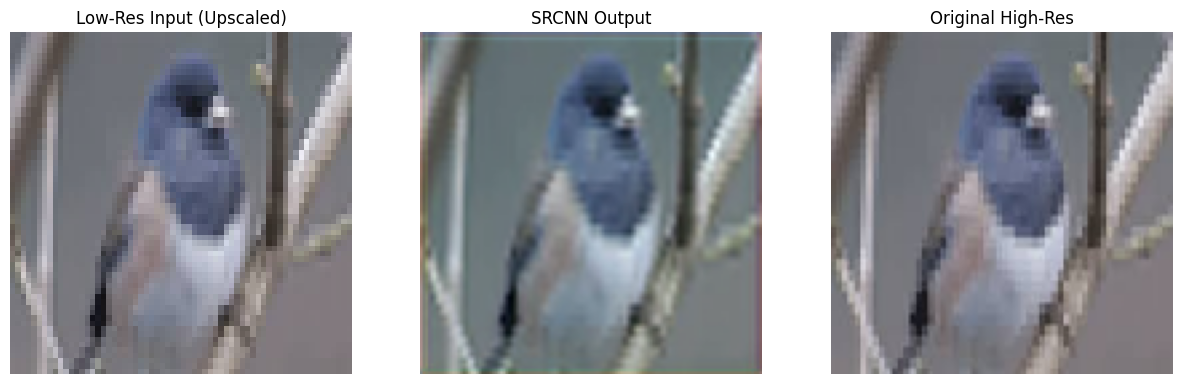

In [ ]:
# 학습된 모델 불러오기
# model = tf.keras.models.load_model('srcnn.h5')

test_image_path = 'image.jpg'

upscale_and_show(test_image_path)